# Classification of Yahoo and 20NewsGroups Dataset


In [1]:
!pip install transformers pandas scikit-learn
!pip install accelerate -U

In [2]:
!git clone https://github.com/amirghavam93/FMNLP_project_STA_LLM.git

fatal: destination path 'FMNLP_project_STA_LLM' already exists and is not an empty directory.


In [3]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Function to read the dataset and return a Dataset object
def load_dataset(data_path):
    data = pd.read_csv(data_path)
    data = data.dropna(axis=0, how='any')
    data['label'] = data['label'].astype(int)
    return data

# Custom dataset class for DistilBERT
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Function to compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Define dataset prefixes and sizes
dataset_prefixes = ['yahoo',]
dataset_sizes = ['50', '100', '500', '1000']

# Dictionary to hold accuracy results
results = {}

# Loop through each dataset
for prefix in dataset_prefixes:
    for size in dataset_sizes:
        # Read datasets
        # /content/FMNLP_project_STA_LLM/data/sst2
        non_aug_data = load_dataset(f'/content/FMNLP_project_STA_LLM/data/{prefix}/{prefix}_{size}.csv')
        aug_data = load_dataset(f'/content/FMNLP_project_STA_LLM/data/{prefix}/augmented_{size}/train_mix.csv')
        test_data = load_dataset(f'/content/FMNLP_project_STA_LLM/data/{prefix}/{prefix}_500_test.csv')

        # Create datasets
        train_dataset = CustomDataset(non_aug_data['text'].tolist(), non_aug_data['label'].tolist(), tokenizer)
        aug_train_dataset = CustomDataset(aug_data['text'].tolist(), aug_data['label'].tolist(), tokenizer)
        test_dataset = CustomDataset(test_data['text'].tolist(), test_data['label'].tolist(), tokenizer)

        # Define training arguments
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=10,
            per_device_train_batch_size=16,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            load_best_model_at_end=True,
            evaluation_strategy='epoch',
            save_strategy="epoch",
        )

        # Initialize model
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=10)

        # Check if CUDA is available and move the model to GPU
        if torch.cuda.is_available():
            model.cuda()

        # Initialize trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics
        )

        # Train the model
        trainer.train()

        # Evaluate the model
        evaluation_results = trainer.evaluate()

        # Store the results
        results[f'{prefix}_{size}_non_aug'] = evaluation_results['eval_accuracy']

        # Repeat the training for the augmented data
        trainer.train_dataset = aug_train_dataset
        trainer.train()
        evaluation_results = trainer.evaluate()
        results[f'{prefix}_{size}_aug'] = evaluation_results['eval_accuracy']

# Print results
for dataset, accuracy in results.items():
    print(f'Accuracy for {dataset}: {accuracy:.2%}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.311597,0.098765
2,No log,2.311375,0.096708
3,No log,2.310951,0.094650
4,No log,2.310427,0.092593
5,No log,2.309749,0.092593
6,No log,2.308839,0.090535
7,No log,2.307766,0.090535
8,No log,2.306599,0.090535
9,No log,2.305225,0.092593
10,No log,2.303681,0.094650


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.301953,0.086420
2,No log,2.296432,0.086420
3,No log,2.290677,0.104938
4,No log,2.279262,0.115226
5,No log,2.254864,0.150206
6,No log,2.206933,0.203704
7,No log,2.165992,0.213992
8,No log,2.112423,0.261317
9,No log,2.088670,0.277778
10,No log,2.159441,0.275720


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.301930,0.094650
2,No log,2.301500,0.092593
3,No log,2.300893,0.088477
4,No log,2.299960,0.090535
5,No log,2.298726,0.088477
6,No log,2.297313,0.086420
7,No log,2.295641,0.086420
8,No log,2.293606,0.086420
9,No log,2.290176,0.086420
10,No log,2.285506,0.088477


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.276980,0.096708
2,No log,2.239728,0.152263
3,No log,2.150724,0.209877
4,No log,2.010699,0.312757
5,No log,1.873288,0.395062
6,No log,1.781603,0.444444
7,No log,1.910576,0.452675
8,No log,2.011707,0.454733
9,No log,2.051873,0.462963
10,No log,2.144195,0.467078


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.298670,0.094650
2,No log,2.287754,0.092593
3,No log,2.250559,0.146091
4,No log,2.140604,0.298354
5,No log,1.943604,0.444444
6,No log,1.738641,0.502058
7,No log,1.561074,0.526749
8,No log,1.511155,0.549383
9,No log,1.481314,0.539095
10,No log,1.527125,0.537037


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.608686,0.528807
2,No log,2.353001,0.500000
3,0.207400,2.652189,0.528807
4,0.207400,2.964407,0.510288
5,0.207400,3.131712,0.508230
6,0.004700,3.291566,0.502058
7,0.004700,3.274100,0.516461
8,0.004700,3.299779,0.518519
9,0.000600,3.321172,0.516461
10,0.000600,3.326693,0.520576


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.287700,0.090535
2,No log,2.131618,0.327160
3,No log,1.738769,0.512346
4,No log,1.538321,0.545267
5,No log,1.406671,0.582305
6,No log,1.487959,0.557613
7,No log,1.632577,0.549383
8,No log,1.763537,0.555556
9,1.290500,1.958048,0.526749
10,1.290500,2.086746,0.543210


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.738672,0.543210
2,0.516600,2.637290,0.526749
3,0.068500,3.110073,0.551440
4,0.068500,3.297423,0.522634
5,0.010700,3.501815,0.526749
6,0.002500,3.514678,0.539095
7,0.003000,3.627134,0.532922
8,0.003000,3.635308,0.532922
9,0.002500,3.657012,0.541152
10,0.001600,3.668788,0.539095


Could not locate the best model at ./results/checkpoint-366/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Accuracy for yahoo_50_non_aug: 9.47%
Accuracy for yahoo_50_aug: 27.78%
Accuracy for yahoo_100_non_aug: 8.85%
Accuracy for yahoo_100_aug: 44.44%
Accuracy for yahoo_500_non_aug: 53.91%
Accuracy for yahoo_500_aug: 52.88%
Accuracy for yahoo_1000_non_aug: 58.23%
Accuracy for yahoo_1000_aug: 53.91%


In [5]:
# Function to read the dataset and return a Dataset object
def load_dataset(data_path):
    data = pd.read_csv(data_path)
    data = data.dropna(axis=1, how='any')  # Drop any columns with NaN values
    label_map = {
            'alt.atheism': 0,
            'comp.graphics': 1,
            'comp.os.ms-windows.misc': 2,
            'comp.sys.ibm.pc.hardware': 3,
            'comp.sys.mac.hardware': 4,
            'comp.windows.x': 5,
            'misc.forsale': 6,
            'rec.autos': 7,
            'rec.motorcycles': 8,
            'rec.sport.baseball': 9,
            'rec.sport.hockey': 10,
            'sci.crypt': 11,
            'sci.electronics': 12,
            'sci.med': 13,
            'sci.space': 14,
            'soc.religion.christian': 15,
            'talk.politics.guns': 16,
            'talk.politics.mideast': 17,
            'talk.politics.misc': 18,
            'talk.religion.misc': 19
            }

    # Map labels using the label_map
    data['label'] = data['label'].map(label_map)
    return data

# Custom dataset class for DistilBERT
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Function to compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Define dataset prefixes and sizes
dataset_prefixes = ['newsgroups',]
dataset_sizes = ['50', '100', '500', '1000']


# Loop through each dataset
for prefix in dataset_prefixes:
    for size in dataset_sizes:
        # Read datasets
        # /content/FMNLP_project_STA_LLM/data/sst2
        non_aug_data = load_dataset(f'/content/FMNLP_project_STA_LLM/data/{prefix}/{prefix}_{size}.csv')
        aug_data = load_dataset(f'/content/FMNLP_project_STA_LLM/data/{prefix}/augmented_{size}/train_mix.csv')
        test_data = load_dataset(f'/content/FMNLP_project_STA_LLM/data/{prefix}/{prefix}_500_test.csv')

        # Create datasets
        train_dataset = CustomDataset(non_aug_data['text'].tolist(), non_aug_data['label'].tolist(), tokenizer)
        aug_train_dataset = CustomDataset(aug_data['text'].tolist(), aug_data['label'].tolist(), tokenizer)
        test_dataset = CustomDataset(test_data['text'].tolist(), test_data['label'].tolist(), tokenizer)

        # Define training arguments
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=10,
            per_device_train_batch_size=16,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            load_best_model_at_end=True,
            evaluation_strategy='epoch',
            save_strategy="epoch",
        )

        # Initialize model
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=20)

        # Check if CUDA is available and move the model to GPU
        if torch.cuda.is_available():
            model.cuda()

        # Initialize trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics
        )

        # Train the model
        trainer.train()

        # Evaluate the model
        evaluation_results = trainer.evaluate()

        # Store the results
        results[f'{prefix}_{size}_non_aug'] = evaluation_results['eval_accuracy']

        # Repeat the training for the augmented data
        trainer.train_dataset = aug_train_dataset
        trainer.train()
        evaluation_results = trainer.evaluate()
        results[f'{prefix}_{size}_aug'] = evaluation_results['eval_accuracy']

# Print results
for dataset, accuracy in results.items():
    print(f'Accuracy for {dataset}: {accuracy:.2%}')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.993560,0.020000
2,No log,2.993375,0.020000
3,No log,2.992983,0.020000
4,No log,2.992421,0.024000
5,No log,2.991723,0.026000
6,No log,2.990907,0.028000
7,No log,2.989993,0.032000
8,No log,2.989078,0.038000
9,No log,2.987954,0.044000
10,No log,2.986531,0.058000


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.984658,0.068000
2,No log,2.976604,0.094000
3,No log,2.950691,0.140000
4,No log,2.895044,0.188000
5,No log,2.809384,0.216000
6,No log,2.712167,0.230000
7,No log,2.614904,0.268000
8,No log,2.503507,0.288000
9,No log,2.394739,0.328000
10,No log,2.327228,0.348000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.993378,0.018000
2,No log,2.992567,0.010000
3,No log,2.991225,0.014000
4,No log,2.989509,0.018000
5,No log,2.987399,0.034000
6,No log,2.984307,0.070000
7,No log,2.980490,0.092000
8,No log,2.975663,0.098000
9,No log,2.968364,0.102000
10,No log,2.957904,0.122000


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.932260,0.168000
2,No log,2.826226,0.250000
3,No log,2.627957,0.284000
4,No log,2.368683,0.356000
5,No log,2.088185,0.450000
6,No log,1.861960,0.504000
7,No log,1.708753,0.492000
8,No log,1.631206,0.504000
9,No log,1.669414,0.506000
10,No log,1.711890,0.506000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.988359,0.034000
2,No log,2.963492,0.110000
3,No log,2.826941,0.302000
4,No log,2.566995,0.400000
5,No log,2.252202,0.468000
6,No log,1.953422,0.526000
7,No log,1.687861,0.600000
8,No log,1.482575,0.622000
9,No log,1.287341,0.662000
10,No log,1.226642,0.656000


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.119545,0.674000
2,No log,1.303511,0.660000
3,0.273900,1.408399,0.720000
4,0.273900,1.493947,0.708000
5,0.273900,1.734885,0.694000
6,0.006700,1.622480,0.722000
7,0.006700,1.655372,0.718000
8,0.001400,1.661710,0.720000
9,0.001400,1.672864,0.720000
10,0.001400,1.675803,0.720000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.967334,0.090000
2,No log,2.602218,0.436000
3,No log,2.003651,0.526000
4,No log,1.525767,0.602000
5,No log,1.201308,0.670000
6,No log,1.012096,0.696000
7,No log,1.044019,0.696000
8,1.556500,1.129440,0.712000
9,1.556500,1.147177,0.728000
10,1.556500,1.117189,0.738000


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.068436,0.720000
2,0.320100,1.377705,0.748000
3,0.042900,1.629120,0.738000
4,0.010300,1.694847,0.742000
5,0.010300,1.975029,0.718000
6,0.004500,1.837418,0.750000
7,0.000400,1.861600,0.746000
8,0.000300,1.894523,0.748000
9,0.000300,1.897874,0.752000
10,0.000300,1.954475,0.736000


Accuracy for yahoo_50_non_aug: 9.47%
Accuracy for yahoo_50_aug: 27.78%
Accuracy for yahoo_100_non_aug: 8.85%
Accuracy for yahoo_100_aug: 44.44%
Accuracy for yahoo_500_non_aug: 53.91%
Accuracy for yahoo_500_aug: 52.88%
Accuracy for yahoo_1000_non_aug: 58.23%
Accuracy for yahoo_1000_aug: 53.91%
Accuracy for newsgroups_50_non_aug: 5.80%
Accuracy for newsgroups_50_aug: 34.80%
Accuracy for newsgroups_100_non_aug: 12.20%
Accuracy for newsgroups_100_aug: 50.40%
Accuracy for newsgroups_500_non_aug: 65.60%
Accuracy for newsgroups_500_aug: 67.40%
Accuracy for newsgroups_1000_non_aug: 69.60%
Accuracy for newsgroups_1000_aug: 72.00%


In [6]:
results = results.items()

# Convert the list of tuples to a dictionary
results = dict(results)

# Now data_dict is a dictionary with the data from list_of_tuples
print(results)

{'yahoo_50_non_aug': 0.09465020576131687, 'yahoo_50_aug': 0.2777777777777778, 'yahoo_100_non_aug': 0.08847736625514403, 'yahoo_100_aug': 0.4444444444444444, 'yahoo_500_non_aug': 0.5390946502057613, 'yahoo_500_aug': 0.5288065843621399, 'yahoo_1000_non_aug': 0.5823045267489712, 'yahoo_1000_aug': 0.5390946502057613, 'newsgroups_50_non_aug': 0.058, 'newsgroups_50_aug': 0.348, 'newsgroups_100_non_aug': 0.122, 'newsgroups_100_aug': 0.504, 'newsgroups_500_non_aug': 0.656, 'newsgroups_500_aug': 0.674, 'newsgroups_1000_non_aug': 0.696, 'newsgroups_1000_aug': 0.72}


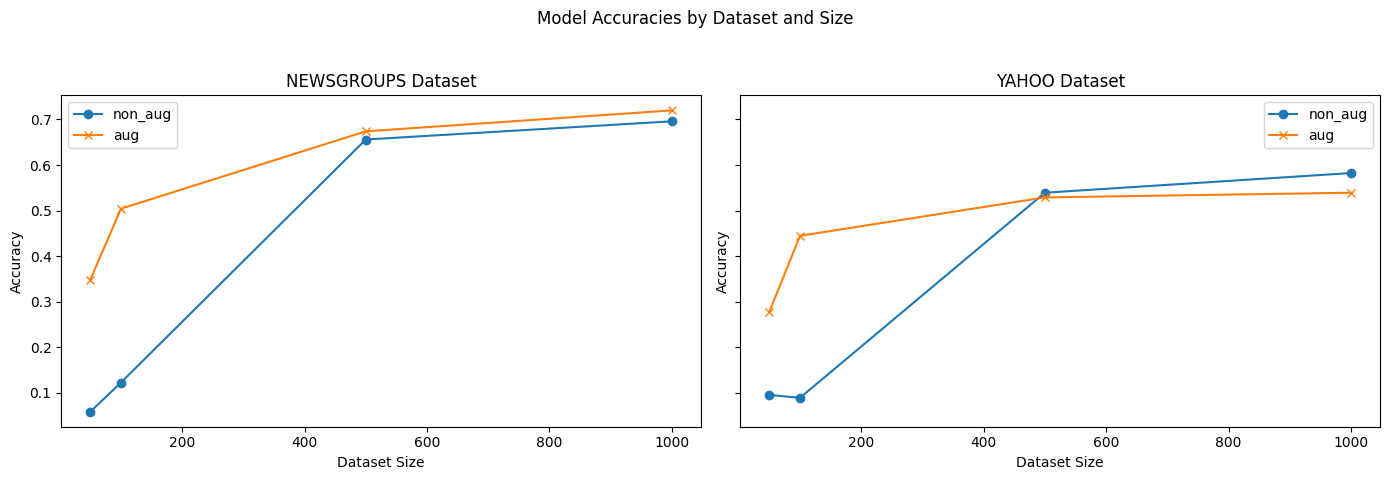

In [8]:
# Extracting the sizes and scores for augmented and non-augmented for both datasets
sizes = ['50', '100', '500', '1000']
datasets = {'newsgroups': [], 'yahoo': []}

# Separating the data by dataset and augmentation type
for size in sizes:
    for dataset in datasets:
        non_aug_key = f'{dataset}_{size}_non_aug'
        aug_key = f'{dataset}_{size}_aug'
        if non_aug_key in results and aug_key in results:
            datasets[dataset].append((results[non_aug_key], results[aug_key]))

# Plotting the data
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, (dataset, scores) in zip(axes, datasets.items()):
    non_aug_scores, aug_scores = zip(*scores)
    sizes_int = [int(size) for size in sizes]

    ax.plot(sizes_int, non_aug_scores, label='non_aug', marker='o')
    ax.plot(sizes_int, aug_scores, label='aug', marker='x')

    ax.set_title(f'{dataset.upper()} Dataset')
    ax.set_xlabel('Dataset Size')
    ax.set_ylabel('Accuracy')
    ax.legend()

plt.suptitle('Model Accuracies by Dataset and Size')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
